In [1]:
import sys 
from pathlib import Path
import torch
import os
import dill
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path
import cv2
import time

sys.path.append("/home/franka_deoxys/diffusion_policy")
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace


sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to

sys.path.append("/home/franka_deoxys/deoxys_vision")
from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info


from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type

# spacemouse = SpaceMouse(vendor_id=9583, product_id=50734) 
#old spacemoue not wireless
spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()
raw_obs_dict_generator = RobotStateRawObsDictGenerator()

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [4]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

### reset robot position (no need to do it from terminal)

In [5]:
# copied from reset_robot_joints.py
# Golden resetting joints
reset_joint_positions = [
        0.037,-1.655,0.099,-2.993,-0.074,2.321,0.921]

# reset_joint_positions= [0.03492503,-1.64946574,0.09731048,-2.99831706,
#                         0.06887073,2.31927159,0.91575789]

In [6]:
reset_joints_to(robot_interface, reset_joint_positions)
# set_gripper(open=True)

JOINT_POSITION


True

In [7]:
if robot_interface._state_buffer:
    last_state = robot_interface._state_buffer[-1]
else:
    print("The state buffer is empty.")
    

### getting lowdim obs + camera obs

In [8]:
camera_ids = [0, 1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


In [9]:
def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]
        
        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))
        
        # color_img = cv2.resize(color_img, ) 


        # color_img = cv2.resize(color_img, (224, 224), fx=0.5, fy=0.5)

        color_img = cv2.resize(color_img, None, fx=0.5, fy=0.5)

        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

In [10]:
data = get_imgs()
print('keys: ', data.keys())

img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
agentview_rgb.shape, eye_in_hand_rgb.shape

keys:  dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])


((240, 320, 3), (240, 320, 3))

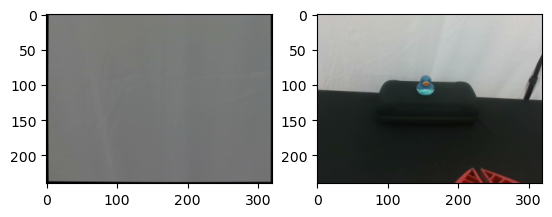

In [11]:
plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [12]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    # print(last_state)
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    # obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

In [26]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
eye_in_hand_rgb (1, 3, 320, 240)


### Now load dp policy

In [25]:
# checkpoint = "/home/franka_deoxys/data_franka/dp_policy/after_train.ckpt"

# checkpoint = "/home/franka_deoxys/data_franka/gib_epoch_100_20250122_162234.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/40good_epoch_700_20250102_033222.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/epoch_400_20250104_131502.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/1000_epochs_40_old_ola.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/bell180_after_train.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/drawer_mixed_700.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/40good_bell_epoch_900_20250121_072728.ckpt"

# checkpoint = "/home/franka_deoxys/data_franka/gib2_epoch_700_20250124_102842.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/drawer_mixed_700.ckpt"

# checkpoint = "/home/franka_deoxys/data_franka/policies/epoch_700_drawer_bell40.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/policies/epoch_700_drawer_bell_60.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/policies/epoch_600_20250127_111354.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/policies/epoch_700_drawer_bellpepper_bed.ckpt"
# checkpoint = "/home/franka_deoxys/data_franka/policies/epoch_700_20250127_131921_gib.ckpt"
checkpoint = '/home/franka_deoxys/riad/diffusion_policy/duck_train/epoch_400_20250227_225952.ckpt'
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'ee_states', 'gripper_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 2.528022e+08
Vision params: 1.119709e+07


In [27]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [28]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


### test prediction on a obs

In [29]:
def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

In [30]:
framestacker=FrameStackForTrans(2)
keys_select = [ 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [31]:
obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

ee_states (16,)
joint_states (7,)
gripper_states (1,)
eye_in_hand_rgb (3, 320, 240)


In [32]:
keys_select = [ 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

In [33]:
framestacker=FrameStackForTrans(2) 
policy.reset()

obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)

In [34]:
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)
action_pred=predict_action(obs)
action_pred

array([[ 0.48 ,  0.005,  0.162,  0.003,  0.03 , -0.008, -1.   ],
       [ 0.478,  0.006,  0.175,  0.002,  0.024, -0.008, -0.998],
       [ 0.499,  0.012,  0.151,  0.002,  0.017, -0.006, -0.998],
       [ 0.499,  0.012,  0.157,  0.001,  0.015, -0.008, -1.   ],
       [ 0.514,  0.012,  0.127,  0.002,  0.01 , -0.008, -0.999],
       [ 0.538,  0.02 ,  0.148, -0.002,  0.011, -0.008, -0.998],
       [ 0.534,  0.013,  0.118,  0.001,  0.005, -0.01 , -0.999],
       [ 0.545,  0.019,  0.119, -0.003,  0.004, -0.009, -0.999]],
      dtype=float32)

Safety Check

In [35]:
import time
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R

In [39]:
###############################################################################
# 1) (Unchanged) Forward Kinematics & Safe-Set Utilities
###############################################################################
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)


def franka_forward_kinematics(joint_angles):
    """
    Convert 7 Franka joint angles -> 4x4 transform in the base frame.
    (Same code as used in your safe-set generation.)
    """
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    # Flange offset
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    return T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Convert 7 Franka joint angles -> [x, y, z, qx, qy, qz, qw].
    (Exactly the same as in your safe-set code.)
    """
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    """
    Convert a 7D pose (position + quaternion) to a minimal 6D representation:
    [x, y, z, rx, ry, rz] where (rx, ry, rz) is the rotation vector.
    """
    pos = pose7d[:3]
    quat = pose7d[3:7]
    norm = np.linalg.norm(quat)
    quat = quat / norm if norm > 1e-6 else np.array([0, 0, 0, 1])
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    A = hull_equations[:, :-1]  # shape (m,6)
    b = hull_equations[:, -1]   # shape (m,)
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_6d) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

###############################################################################
# 2) Visualization (optional, unchanged from your snippet)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()


def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    """
    If pose_7d is inside the safe set, push it slightly outside along the facet
    with the largest distance. This ensures the resulting pose is outside by
    at least 'margin'.

    pose_7d: [x,y,z, qx,qy,qz,qw]
    hull_equations: from your .npz file => hull_equations
    margin: how far beyond the hull to push
    tol: tolerance to treat as "inside"

    Returns:
      new_pose_7d: The pose (7D) guaranteed to be outside the safe set.
    """
    # 1) Convert to 6D (pos + rotation vector)
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        # Already outside => return as-is
        return pose_7d

    # 2) Find the facet with the maximum distance
    #    Typically, distances for an inside point are <= 0 or negative, but we pick
    #    the largest anyway. We'll push along that normal.
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]   # normal vector
    norm_A = np.linalg.norm(A_i)

    # 3) Compute shift => we move (tol - d_max + margin) along the normal
    #    so that the new point is just outside by 'margin'.
    shift_6d = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift_6d

    # 4) Convert back to 7D => new position + orientation
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d


In [40]:
safe_set_file="Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

### Now run inference in loop

JOINT_POSITION


In [42]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(50):
    # 1) Acquire user input
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred[:4]):
        print(f"Sending to robot: action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.05)

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        print(f"   => inside={inside}, distances={distances}")

        # 7) Collect for final visualization
        all_poses_7d.append(eef_pose_7d)
        all_inside_flags.append(inside)

robot_interface.close()

JOINT_POSITION
from controller:  [0. 0. 0.] [0. 0. 0.]
Sending to robot: action 0 => [ 0.389  0.     0.096  0.011 -0.009  0.004 -0.996]
   => inside=True, distances=[-0.303 -0.076 -1.054 ... -0.129 -0.13  -0.126]
Sending to robot: action 1 => [ 0.393 -0.001  0.085  0.015 -0.003  0.001 -1.   ]
   => inside=True, distances=[-0.306 -0.075 -1.069 ... -0.141 -0.141 -0.138]
Sending to robot: action 2 => [ 0.427  0.002  0.078  0.008  0.003 -0.003 -0.999]
   => inside=True, distances=[-0.309 -0.072 -1.083 ... -0.154 -0.154 -0.151]
Sending to robot: action 3 => [ 0.435  0.001  0.073  0.006  0.006 -0.004 -1.   ]
   => inside=True, distances=[-0.315 -0.067 -1.104 ... -0.173 -0.173 -0.17 ]
from controller:  [0. 0. 0.] [0. 0. 0.]
Sending to robot: action 0 => [ 0.248 -0.003  0.113  0.008  0.034  0.006 -0.999]
   => inside=True, distances=[-0.326 -0.057 -1.152 ... -0.219 -0.218 -0.216]
Sending to robot: action 1 => [ 0.28  -0.     0.126  0.006  0.03   0.001 -1.   ]
   => inside=True, distances=[-0.3

KeyboardInterrupt: 

In [59]:
js_real = robot_interface.last_q
js_real

array([ 0.037, -1.654,  0.099, -2.993, -0.073,  2.32 ,  0.921])

In [43]:
# 8) Visualize final real EEF poses vs. safe set
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Real Joints after Action)"
    )
else:
    print("No EEF poses to visualize.")

In [49]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


In [42]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
all_poses_7d = []
all_inside_flags=[]

def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        return pose_7d
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]
    norm_A = np.linalg.norm(A_i)
    shift = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d


def push_robot_outside_loop(robot_interface, hull_equations, max_tries=10, margin=1e-6, tol=1e-12):
    """
    Repeatedly check if robot is inside safe set, if so push it out
    and command the new pose, up to `max_tries`.
    """
    tries = 0
    while tries < max_tries:
        # read real joints
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read, skip attempt.")
            time.sleep(0.05)
            tries += 1
            continue

        # convert to 7D
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
        pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
        # 7) Collect for final visualization
        all_poses_7d.append(eef_pose_7d)
        all_inside_flags.append(inside)
        if not inside:
            print("Already outside the safe set!")
            break

        # push it
        pushed_pose_7d = push_pose_outside_safe_set_7d(eef_pose_7d, hull_equations, margin, tol)
        print(f"Push attempt {tries}: new pose => {pushed_pose_7d}")

        # command the new pose
        robot_interface.control(
            controller_type="OSC_POSE",  # or your controller
            action=pushed_pose_7d,
            controller_cfg=controller_cfg,
        )

        time.sleep(0.5)
        tries += 1

    if tries >= max_tries:
        print("Reached max tries; might still be inside or can't push further.")


###############################################################################
# 3) Example integrated with your policy rollout: push after 4 steps
###############################################################################
# def main_policy_rollout_with_push(robot_interface, hull_equations, policy, max_steps=10):
policy.reset()

for step in range(50):
    # 1) Acquire user input, or do something else
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Predict actions (whatever your policy returns)
    obs_dict = get_current_obs(robot_interface)
    obs = framestacker.add_new_obs(obs_dict)
    action_pred = predict_action(obs)  # shape (N,7) or (N,6), etc.
    print(f"Step {step}:")

    # 3) Send some subset of those actions to the robot
    for i, single_cmd in enumerate(action_pred[:6]):  # e.g. first 6
        print(f"Sending action {i} => {single_cmd}")
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.1)
    
    # convert to 7D
    js_real = robot_interface.last_q
    if js_real is None:
        print("No joint angles read, skip attempt.")
        time.sleep(0.05)
        # tries += 1
        continue
    eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
    pose_6d = pose7d_to_6d(eef_pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, 1e-1)
    
    # 7) Collect for final visualization
    all_poses_7d.append(eef_pose_7d)
    all_inside_flags.append(inside)

    # 4) At step == 4, do the "push outside" loop
    if step == 6:
        print("Now pushing the robot outside the safe set!")
        push_robot_outside_loop(robot_interface, hull_equations, max_tries=10, margin=1e-3)
        # After the push loop, we continue normal steps
        # Or if you prefer, you could break out entirely.

robot_interface.close()

JOINT_POSITION


KeyboardInterrupt: 

In [40]:
# 8) Visualize final real EEF poses vs. safe set
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Real Joints after Action)"
    )
else:
    print("No EEF poses to visualize.")

In [58]:
def dh_transform(a, alpha, d, theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [0,              0,                            0,                            1              ]
    ], dtype=float)

def franka_forward_kinematics_panda_hand(joint_angles):
    """
    Returns a 4x4 transform from the panda base to the 'panda_hand' link.
    """
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    
    # DH transforms up to the flange (link8 in the URDF).
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    
    # Flange offset (link8).
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    
    # Extra rotation from flange -> panda_hand (about Z by -π/4).
    Rz_neg_45 = dh_transform(a=0, alpha=0, d=0, theta=-np.pi/4)

    T_panda_hand = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7 @ T_flange @ Rz_neg_45
    return T_panda_hand

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Convert 7 Franka joint angles -> [x, y, z, qx, qy, qz, qw].
    (Exactly the same as in your safe-set code.)
    """
    T = franka_forward_kinematics(joint_angles)
    x, y, z = T[0, 3], T[1, 3], T[2, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    return np.array([x, y, z, quat[0], quat[1], quat[2], quat[3]], dtype=float)

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    return q / norm if norm > 1e-6 else np.array([0, 0, 0, 1])

def pose7d_to_6d(pose7d):
    """
    Convert a 7D pose (position + quaternion) to a minimal 6D representation:
    [x, y, z, rx, ry, rz] where (rx, ry, rz) is the rotation vector.
    """
    pos = pose7d[:3]
    quat = pose7d[3:7]
    norm = np.linalg.norm(quat)
    quat = quat / norm if norm > 1e-6 else np.array([0, 0, 0, 1])
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def load_safe_set(file_path="safe_set_6d.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    A = hull_equations[:, :-1]  # shape (m,6)
    b = hull_equations[:, -1]   # shape (m,)
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_6d) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

###############################################################################
# 2) Visualization (optional, unchanged from your snippet)
###############################################################################
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    hull_3d = ConvexHull(safe_set[:, :3])
    fig = go.Figure()
    fig.add_trace(go.Mesh3d(
        x=safe_set[:, 0],
        y=safe_set[:, 1],
        z=safe_set[:, 2],
        i=hull_3d.simplices[:, 0],
        j=hull_3d.simplices[:, 1],
        k=hull_3d.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    predicted_positions = predicted_poses_7d[:, :3]
    colors = ["green" if flag else "red" for flag in inside_flags]
    fig.add_trace(go.Scatter3d(
        x=predicted_positions[:, 0],
        y=predicted_positions[:, 1],
        z=predicted_positions[:, 2],
        mode='markers+lines',
        marker=dict(size=5, color=colors),
        line=dict(color='gray', width=2),
        name='EEF Poses (Real Joints)'
    ))
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    fig.show()


def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    """
    If pose_7d is inside the safe set, push it slightly outside along the facet
    with the largest distance. This ensures the resulting pose is outside by
    at least 'margin'.

    pose_7d: [x,y,z, qx,qy,qz,qw]
    hull_equations: from your .npz file => hull_equations
    margin: how far beyond the hull to push
    tol: tolerance to treat as "inside"

    Returns:
      new_pose_7d: The pose (7D) guaranteed to be outside the safe set.
    """
    # 1) Convert to 6D (pos + rotation vector)
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        # Already outside => return as-is
        return pose_7d

    # 2) Find the facet with the maximum distance
    #    Typically, distances for an inside point are <= 0 or negative, but we pick
    #    the largest anyway. We'll push along that normal.
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]   # normal vector
    norm_A = np.linalg.norm(A_i)

    # 3) Compute shift => we move (tol - d_max + margin) along the normal
    #    so that the new point is just outside by 'margin'.
    shift_6d = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift_6d

    # 4) Convert back to 7D => new position + orientation
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d
def compose_new_pose_7d(current_pose_7d, delta_action, trans_scale=0.06, rot_scale=1.2):
    """
    Compute a new 7D pose by applying a scaled delta action to the current 7D pose.
    Parameters:
      current_pose_7d: [x, y, z, qx, qy, qz, qw]
      delta_action: [dx, dy, dz, dax, day, daz, gripper]
      trans_scale: scaling for translation
      rot_scale: scaling for rotation (axis-angle)
    Returns:
      new_pose_7d: [x, y, z, qx, qy, qz, qw]
    """
    
    delta_trans = trans_scale * delta_action[:3]
    delta_rot = rot_scale * delta_action[3:6]
    new_pos = current_pose_7d[:3] + delta_trans
    current_quat = current_pose_7d[3:7]

    delta_quat = R.from_rotvec(delta_rot).as_quat()
    new_rot = R.from_quat(current_quat) * R.from_quat(delta_quat)
    new_quat = normalize_quaternion(new_rot.as_quat())
    
    new_pose= np.hstack([new_pos, new_quat,current_pose_7d[-1]])
    
    # absolute_correct_robot_pose(robot_interface, new_pose)
    return new_pose

safe_set_file="Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

In [55]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)

JOINT_POSITION


In [56]:

### Now run inference in loop

# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []
js = robot_interface.last_q
if js is None:
    raise ValueError("No joint angles available to compute the initial pose.")
initial_pose = joint_angles_to_end_effector_pose(js)
print("Initial computed 7D Pose from joint angles:", initial_pose)
# Store the current pose
current_pose_7d = initial_pose.copy()

for _ in range(50):
    # 1) Acquire user input
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # Compute the initial pose from joint angles
    

    

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred[:4]):
        print(f"Sending to robot: action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.05)
        predicted_pose = compose_new_pose_7d(current_pose_7d, single_cmd)
        predicted_pose_6d = pose7d_to_6d(predicted_pose)
        inside, distances = is_pose_in_safe_set_6d(predicted_pose_6d, hull_equations, tol=1e-1)
        print("Predicted: ",predicted_pose)

        print(f"  Safe set check: inside = {inside}")

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        print("Actual ",eef_pose_7d)
        # eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        # inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        # print(f"   => inside={inside}, distances={distances}")

        # 7) Collect for final visualization
        all_poses_7d.append(predicted_pose)
        all_inside_flags.append(inside)

robot_interface.close()

JOINT_POSITION
Initial computed 7D Pose from joint angles: [ 0.606 -0.081  0.346 -0.374  0.821 -0.175 -0.395]
from controller:  [0. 0. 0.] [ 0.  0. -0.]
Sending to robot: action 0 => [ 0.23   0.008  0.208  0.005 -0.055  0.003 -0.991]
Predicted:  [ 0.615 -0.08   0.355 -0.378  0.831 -0.168 -0.373 -0.395]
  Safe set check: inside = False
Actual  [ 0.606 -0.08   0.346 -0.374  0.821 -0.175 -0.395]
Sending to robot: action 1 => [ 0.232  0.004  0.178  0.014 -0.044 -0.001 -0.993]
Predicted:  [ 0.616 -0.081  0.353 -0.38   0.827 -0.173 -0.376 -0.395]
  Safe set check: inside = False
Actual  [ 0.611 -0.076  0.346 -0.395  0.811 -0.186 -0.39 ]
Sending to robot: action 2 => [ 0.249  0.007  0.21   0.011 -0.024  0.003 -0.99 ]
Predicted:  [ 0.616 -0.08   0.355 -0.377  0.825 -0.176 -0.384 -0.395]
  Safe set check: inside = False
Actual  [ 0.615 -0.072  0.346 -0.407  0.804 -0.193 -0.387]
Sending to robot: action 3 => [ 0.257  0.004  0.163  0.009 -0.026  0.002 -0.997]
Predicted:  [ 0.617 -0.081  0.353 -0.

KeyboardInterrupt: 

In [59]:
from deoxys.utils import ik_utils

In [57]:
# 8) Visualize final real EEF poses vs. safe set
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Real Joints after Action)"
    )
else:
    print("No EEF poses to visualize.")

In [36]:
import os
import time
import numpy as np
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

# -----------------------------------------------------------------------------
# 1) Utility Functions
# -----------------------------------------------------------------------------
def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    if norm < 1e-6:
        return np.array([0, 0, 0, 1])
    return q / norm

def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)

def franka_forward_kinematics(joint_angles):
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    T = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7
    # Flange offset
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    return T @ T_flange

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Compute the 7D pose [x, y, z, qx, qy, qz, qw] using forward kinematics.
    """
    T = franka_forward_kinematics(joint_angles)
    pos = T[:3, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    quat = normalize_quaternion(quat)
    return np.hstack([pos, quat])

# -----------------------------------------------------------------------------
# 2) Safe Set Functions
# -----------------------------------------------------------------------------
def load_safe_set(file_path="safe_set_6d_dummy.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

def pose7d_to_6d(pose7d):
    """
    Convert a 7D pose (position + quaternion) to a minimal 6D representation:
    [x, y, z, rx, ry, rz] where (rx, ry, rz) is the rotation vector.
    """
    pos = pose7d[:3]
    quat = pose7d[3:7]
    norm = np.linalg.norm(quat)
    quat = quat / norm if norm > 1e-6 else np.array([0, 0, 0, 1])
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    A = hull_equations[:, :-1]
    b = hull_equations[:, -1]
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_6d) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

def quat_to_axis_angle_pose(pose7d):
    """
    Convert a 7D pose (position and quaternion) to a 6D pose (position and axis–angle).
    
    Parameters:
      pose7d: A numpy array or list with 7 elements [x, y, z, qx, qy, qz, qw].
      
    Returns:
      A numpy array with 6 elements [x, y, z, rx, ry, rz], where [rx, ry, rz]
      is the rotation vector (axis–angle representation).
    """
    pos = np.array(pose7d[:3])
    quat = np.array(pose7d[3:7])
    
    # Normalize the quaternion to avoid errors.
    norm = np.linalg.norm(quat)
    if norm < 1e-6:
        quat = np.array([0, 0, 0, 1])
    else:
        quat = quat / norm
    
    # Convert the normalized quaternion to a rotation vector (axis–angle).
    rotvec = R.from_quat(quat).as_rotvec()
    
    # Combine position and rotation vector.
    pose6d = np.hstack([pos, rotvec])
    return pose6d

# -----------------------------------------------------------------------------
# 3) Pose Composition
# -----------------------------------------------------------------------------
def compose_new_pose_7d(current_pose_7d, delta_action, trans_scale=1.0, rot_scale=1.0):
    """
    Compute a new 7D pose by applying a scaled delta action to the current 7D pose.
    Parameters:
      current_pose_7d: [x, y, z, qx, qy, qz, qw]
      delta_action: [dx, dy, dz, dax, day, daz, gripper]
      trans_scale: scaling for translation
      rot_scale: scaling for rotation (axis-angle)
    Returns:
      new_pose_7d: [x, y, z, qx, qy, qz, qw]
    """
    
    delta_trans = trans_scale * delta_action[:3]
    delta_rot = rot_scale * delta_action[3:6]
    new_pos = current_pose_7d[:3] + delta_trans
    current_quat = current_pose_7d[3:7]

    delta_quat = R.from_rotvec(delta_rot).as_quat()
    new_rot = R.from_quat(current_quat) * R.from_quat(delta_quat)
    new_quat = normalize_quaternion(new_rot.as_quat())
    
    new_pose= np.hstack([new_pos, new_quat,current_pose_7d[-1]])
    new_pose_axis=quat_to_axis_angle_pose(new_pose)
    # absolute_correct_robot_pose(robot_interface, new_pose)
    return new_pose,new_pose_axis

def absolute_correct_robot_pose(robot_interface, desired_pose):
    """
    Commands the robot with an absolute desired pose until it reaches that pose.
    
    Assumptions:
      - desired_pose is a 7D pose: [x, y, z, qx, qy, qz, qw].
      - robot_interface.last_q returns the current joint angles.
      - joint_angles_to_end_effector_pose(js) converts joint angles to a 7D pose.
      - pose7d_to_6d(pose7d) converts a 7D pose (with quaternion) into a 6D pose: [x, y, z, rx, ry, rz].
      - The control function is configured with is_delta=False so that the command is interpreted as an exact pose.
    
    The function repeatedly sends the exact desired pose until the positional and rotational
    errors are within specified tolerances.
    """
    MAX_CORRECTION_ITERS = 100
    for iter_count in range(MAX_CORRECTION_ITERS):
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Retrying...")
            continue

        # Get the current end-effector pose in 7D.
        actual_pose = joint_angles_to_end_effector_pose(js_real)
        
        # Compute errors between desired and actual pose.
        pos_err, rot_err = compute_pose_error(desired_pose, actual_pose)
        pos_norm = np.linalg.norm(pos_err)
        rot_norm = np.linalg.norm(rot_err)
        
        print(f"[Absolute Correction Iter {iter_count+1}] Pos Err: {pos_err} (norm {pos_norm}), "
              f"Rot Err: {rot_err} (norm {rot_norm})")

        # If both errors are within tolerance, stop.
        if pos_norm < POSITION_TOLERANCE and rot_norm < ROTATION_TOLERANCE:
            print("Robot has reached the desired pose.")
            break

        # Convert the desired 7D pose to a 6D pose command.
        desired_pose_6d = pose7d_to_6d(desired_pose)
        print(f"Sending absolute desired pose: {desired_pose_6d}")

        # Send the absolute pose command to the robot.
        robot_interface.control(
            controller_type=controller_type,
            action=desired_pose_6d,
            controller_cfg=controller_cfg  # Ensure is_delta is set to False in this config.
        )
        time.sleep(0.1)

# def compose_new_pose_7d(current_pose_7d, target_pose_7d):
#     """
#     Compose a new absolute 7D pose from an exact target pose given in axis–angle form.
    
#     Parameters:
#       robot_interface: The robot interface used to send commands.
#       current_pose_7d: Current pose [x, y, z, qx, qy, qz, qw] (or 8D if a gripper value is appended).
#       target_pose_6d: Absolute target pose [x, y, z, rx, ry, rz],
#                       where [rx, ry, rz] is the rotation expressed as an axis–angle vector.
    
#     Returns:
#       new_pose_7d: Absolute pose [x, y, z, qx, qy, qz, qw] (or with gripper value appended).
#     """
#     # The position is given directly.
#     new_pos = target_pose_7d[:3]
    
#     # Convert the target axis–angle rotation (3D rotation vector) to a quaternion.
#     new_quat = R.from_rotvec(target_pose_7d[3:6]).as_quat()
    
#     # If the current pose includes a gripper value (8D), preserve it.
#     if len(current_pose_7d) > 7:
#         gripper_val = current_pose_7d[7]
#         new_pose = np.hstack([new_pos, new_quat, gripper_val])
#     else:
#         new_pose = np.hstack([new_pos, new_quat,-1])
    
#     # Command the robot with the absolute (exact) desired pose.
#     # absolute_correct_robot_pose(robot_interface, new_pose)
    
#     return new_pose


# -----------------------------------------------------------------------------
# 4) Visualization Function
# -----------------------------------------------------------------------------
def visualize_policy_predictions(safe_set, predicted_poses_7d, inside_flags, title="Policy Predictions vs. Safe Set"):
    """
    Visualize the safe set and the predicted 7D end-effector poses.
    The safe set is plotted as a 3D convex hull (using the position part) and the
    predicted poses are overlaid as scatter points.
    Points that are inside the safe set are colored green; those outside are red.
    """
    # Compute the convex hull from the safe set (positions only, first 3 dims)
    hull = ConvexHull(safe_set[:, :3])
    
    # Create mesh data for the convex hull
    x_hull = safe_set[:, 0]
    y_hull = safe_set[:, 1]
    z_hull = safe_set[:, 2]
    
    # Prepare colors based on inside_flags
    colors = ["green" if flag else "red" for flag in inside_flags]
    
    fig = go.Figure()
    # Plot the safe set hull as a 3D mesh.
    fig.add_trace(go.Mesh3d(
        x=x_hull, y=y_hull, z=z_hull,
        i=hull.simplices[:, 0],
        j=hull.simplices[:, 1],
        k=hull.simplices[:, 2],
        opacity=0.3,
        color='lightblue',
        name='Safe Set Hull'
    ))
    
    # Plot the predicted poses as scatter points (using positions only).
    fig.add_trace(go.Scatter3d(
        x=predicted_poses_7d[:, 0],
        y=predicted_poses_7d[:, 1],
        z=predicted_poses_7d[:, 2],
        mode='markers',
        marker=dict(size=5, color=colors),
        name='Predicted Poses'
    ))
    
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )
    
    fig.show()

POSITION_TOLERANCE = 1e-2  # meters
ROTATION_TOLERANCE = 1e-2  # radians

def compute_pose_error(target_pose, current_pose):
    """
    Compute position and orientation error between target_pose and current_pose.
    
    Both poses are assumed to be 7D: [x, y, z, qx, qy, qz, qw], where the quaternion is normalized.
    
    The rotational error is computed via the error quaternion:
      q_error = q_target * (q_current)^(-1)
    and converted to a rotation vector (axis-angle representation).
    """
    # Position error:
    pos_error = target_pose[:3] - current_pose[:3]
    
    # Rotational error:
    q_target = target_pose[3:7]
    q_current = current_pose[3:7]
    # For unit quaternions, the inverse is the conjugate:
    q_current_inv = np.array([-q_current[0], -q_current[1], -q_current[2], q_current[3]])
    # Compute error quaternion:
    q_error = R.from_quat(q_target) * R.from_quat(q_current_inv)
    # Convert error quaternion to axis-angle (rotation vector)
    rot_error = q_error.as_rotvec()
    
    return pos_error, rot_error

def dynamic_correct_robot_pose(robot_interface, desired_pose):
    MAX_CORRECTION_ITERS = 100
    MIN_GAIN = 0.1
    MAX_GAIN = 1.0
    FIXED_ROT_GAIN = 0.5  # Tune this fixed gain for rotation as needed
    
    for iter_count in range(MAX_CORRECTION_ITERS):
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Retrying...")
            continue
        
        actual_pose = joint_angles_to_end_effector_pose(js_real)
        pos_err, rot_err = compute_pose_error(desired_pose, actual_pose)
        
        pos_norm = np.linalg.norm(pos_err)
        rot_norm = np.linalg.norm(rot_err)
        print(f"[Dynamic Correction Iter {iter_count+1}] Pos Err: {pos_err} (norm {pos_norm}), Rot Err: {rot_err} (norm {rot_norm})")
        
        if pos_norm < POSITION_TOLERANCE and rot_norm < ROTATION_TOLERANCE:
            print("Robot has reached the desired pose.")
            break
        
        # Dynamic gain for translation (capped between MIN_GAIN and MAX_GAIN)
        trans_gain = np.clip(pos_norm, MIN_GAIN, MAX_GAIN)
        # Use a fixed gain for rotation
        rot_gain = FIXED_ROT_GAIN
        
        # Translation correction component:
        trans_corr = pos_err * trans_gain
        
        # Rotational correction:
        # rot_err is already an axis–angle vector (axis * angle)
        # Scale the angle by rot_gain. Depending on your control convention you may need to invert the sign.
        delta_rot = rot_err * rot_gain
        # If your control function expects the correction in the opposite direction, use -delta_rot:
        rot_corr = -delta_rot
        
        # Combine into a 6D correction vector: [dx, dy, dz, axis_x*delta_angle, axis_y*delta_angle, axis_z*delta_angle]
        correction = np.hstack([trans_corr, rot_corr])
        print(f"Applying dynamic correction: {correction}")
        
        robot_interface.control(
            controller_type=controller_type,
            action=correction,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.05)




POSITION_TOLERANCE = 1e-1  # meters
ROTATION_TOLERANCE = 1e-1  # radians
MAX_CORRECTION_ITERS = 20  # Maximum iterations for safety
TRANSLATIONAL_GAIN = 0.5   # Adjust as needed
ROTATIONAL_GAIN = 0.5     # Adjust as needed

def decoupled_correct_robot_pose(robot_interface, desired_pose):
    """
    Corrects the robot's pose in two decoupled phases:
      1. Orientation correction: apply pure rotational corrections.
      2. Translation correction: apply pure translational corrections.
    """
    iter_count = 0

    # Phase 1: Correct Rotation First
    while iter_count < MAX_CORRECTION_ITERS:
        iter_count += 1
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Retrying rotation correction...")
            continue
        
        actual_pose = joint_angles_to_end_effector_pose(js_real)
        pos_error, rot_error = compute_pose_error(desired_pose, actual_pose)
        
        if np.linalg.norm(rot_error) < ROTATION_TOLERANCE:
            print("Rotation error within tolerance.")
            break
        
        # Apply only rotational correction (zero translation)
        correction = np.hstack([np.zeros(3), -rot_error * ROTATIONAL_GAIN,desired_pose[-1]])
        # print(f"[Rotation Correction Iter {iter_count}] Applying correction: {correction}")
        robot_interface.control(
            controller_type=controller_type,
            action=correction,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.05)
    
    # Phase 2: Correct Translation Next
    iter_count = 0
    while iter_count < MAX_CORRECTION_ITERS:
        iter_count += 1
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Retrying translation correction...")
            continue
        
        actual_pose = joint_angles_to_end_effector_pose(js_real)
        pos_error, rot_error = compute_pose_error(desired_pose, actual_pose)
        
        if np.linalg.norm(pos_error) < POSITION_TOLERANCE:
            print("Translation error within tolerance.")
            break
        
        # Apply only translational correction (zero rotation)
        correction = np.hstack([pos_error * TRANSLATIONAL_GAIN, np.zeros(3),desired_pose[-1]])
        # print(f"[Translation Correction Iter {iter_count}] Applying correction: {correction}")
        robot_interface.control(
            controller_type=controller_type,
            action=correction,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.05)
    
    print("Decoupled correction completed.")

def absolute_correct_robot_pose(robot_interface, desired_pose):
    """
    Commands the absolute desired pose (as a 6D vector: [x, y, z, rx, ry, rz])
    repeatedly until the robot's current pose is within tolerances.

    Assumes:
      - desired_pose is a 7D vector: [x, y, z, qx, qy, qz, qw]
      - robot_interface.last_q is used to compute the current pose via forward kinematics.
      - pose7d_to_6d converts a 7D pose (with quaternion) into a 6D pose (position and rotation vector).
      - The control function is configured with is_delta=False.
    """
    MAX_CORRECTION_ITERS = 100
    for iter_count in range(MAX_CORRECTION_ITERS):
        js_real = robot_interface.last_q
        if js_real is None:
            print("No joint angles read. Retrying...")
            continue

        actual_pose = joint_angles_to_end_effector_pose(js_real)
        pos_err, rot_err = compute_pose_error(desired_pose, actual_pose)
        pos_norm = np.linalg.norm(pos_err)
        rot_norm = np.linalg.norm(rot_err)
        print(f"[Absolute Correction Iter {iter_count+1}] Pos Err: {pos_err} (norm {pos_norm}), Rot Err: {rot_err} (norm {rot_norm})")

        if pos_norm < POSITION_TOLERANCE and rot_norm < ROTATION_TOLERANCE:
            print("Robot has reached the desired pose.")
            break

        # Convert the desired 7D pose to a 6D absolute pose command.
        desired_pose_6d = pose7d_to_6d(desired_pose)
        print(f"Sending absolute desired pose: {desired_pose_6d}")
        robot_interface.control(
            controller_type=controller_type,
            action=desired_pose_6d,
            controller_cfg=controller_cfg,  # Ensure is_delta=False is set here.
        )
        time.sleep(0.1)


# -----------------------------------------------------------------------------
# 2) Main Policy Rollout Loop
# -----------------------------------------------------------------------------

# Controller configuration
ACTION_SCALE_TRANSLATION = 0.05
ACTION_SCALE_ROTATION = 1.0


# Load safe set
safe_set_file = "Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)


In [33]:
# Reset robot and policy
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

JOINT_POSITION


In [38]:
# Reset robot and policy
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

# Compute the initial pose from joint angles
js = robot_interface.last_q
if js is None:
    raise ValueError("No joint angles available to compute the initial pose.")
initial_pose = joint_angles_to_end_effector_pose(js)
print("Initial computed 7D Pose from joint angles:", initial_pose)

# Store the current pose
current_pose_7d = initial_pose.copy()

# Policy Execution Loop
for step in range(10):
    print(f"\n--- Step {step+1} ---")

    # Acquire user input
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # Policy predicts delta actions
    action_pred = predict_action(obs)

    for i, delta_action in enumerate(action_pred[:4]):
        # Compute predicted pose using stored pose and delta action
        # predicted_pose = compose_new_pose_7d(current_pose_7d, delta_action,
        #                                      trans_scale=ACTION_SCALE_TRANSLATION,
        #                                      rot_scale=ACTION_SCALE_ROTATION)
        predicted_pose,predicted_axis_pose = compose_new_pose_7d(current_pose_7d, delta_action)
        predicted_pose_6d = pose7d_to_6d(predicted_pose)
        inside, distances = is_pose_in_safe_set_6d(predicted_pose_6d, hull_equations, tol=1e-1)

        print(f"  Safe set check: inside = {inside}")

        # Send the delta action to the robot
        print(f"Sending action {i} to robot: {delta_action}")
        robot_interface.control(
            controller_type=controller_type,
            action=delta_action,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.05)

        

        # **NEW: Correct the pose if necessary**
        

        # # Read the actual joint angles after action execution
        # js_real = robot_interface.last_q
        # if js_real is None:
        #     print("No joint angles read. Skipping.")
        #     continue

        # # Convert real joints => actual EEF pose => 6D representation
        # eef_pose_7d = joint_angles_to_end_effector_pose(js_real)
        # eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        # inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        # print(f"   => inside={inside}, distances={distances}")

        # Store for final visualization
        all_poses_7d.append(predicted_pose)
        all_inside_flags.append(inside)
        

        

        # Update stored pose
        current_pose_7d = predicted_pose.copy()
        print("Stored updated 7D pose for next iteration:", current_pose_7d)

robot_interface.close()

JOINT_POSITION
Initial computed 7D Pose from joint angles: [ 0.606 -0.081  0.346 -0.374  0.821 -0.175 -0.395]

--- Step 1 ---
from controller:  [0. 0. 0.] [0. 0. 0.]
  Safe set check: inside = False
Sending action 0 to robot: [ 0.32  -0.09   0.117 -0.016  0.137 -0.029 -0.987]
Stored updated 7D pose for next iteration: [ 0.927 -0.171  0.463 -0.369  0.788 -0.188 -0.456 -0.395]
  Safe set check: inside = False
Sending action 1 to robot: [ 0.334 -0.092  0.079 -0.02   0.125 -0.012 -0.996]
Stored updated 7D pose for next iteration: [ 1.26  -0.263  0.542 -0.357  0.757 -0.2   -0.509 -0.395]
  Safe set check: inside = False
Sending action 2 to robot: [ 0.365 -0.08   0.117 -0.028  0.118  0.003 -0.994]
Stored updated 7D pose for next iteration: [ 1.625 -0.343  0.659 -0.336  0.729 -0.211 -0.558 -0.395]
  Safe set check: inside = False
Sending action 3 to robot: [ 0.361 -0.089  0.101 -0.033  0.14  -0.011 -0.994]
Stored updated 7D pose for next iteration: [ 1.986 -0.432  0.76  -0.315  0.69  -0.219 -

KeyboardInterrupt: 

In [37]:
# ---- Visualize the Final Real End-Effector Poses vs. the Safe Set ----
all_poses_7d = np.array(all_poses_7d)
all_inside_flags = np.array(all_inside_flags, dtype=bool)
if len(all_poses_7d) > 0:
    visualize_policy_predictions(
        safe_set,
        predicted_poses_7d=all_poses_7d,
        inside_flags=all_inside_flags,
        title="Policy vs. Safe Set (Predicted Poses)"
    )
else:
    print("No EEF poses to visualize.")

In [27]:
import numpy as np
from scipy.spatial.transform import Rotation as R, Slerp

def linear_pose_interpolation(start_pose, goal_pose, t):
    """
    Interpolate between two 7D poses (position and quaternion) linearly.
    
    Parameters:
      start_pose: 7D pose as [x, y, z, qx, qy, qz, qw]
      goal_pose: 7D pose as [x, y, z, qx, qy, qz, qw]
      t: interpolation parameter in [0, 1]
      
    Returns:
      interp_pose: 7D interpolated pose [x, y, z, qx, qy, qz, qw]
    """
    # Linearly interpolate position (LERP)
    pos_interp = (1 - t) * start_pose[:3] + t * goal_pose[:3]
    
    # Interpolate orientation using Slerp
    # Create Rotation objects from quaternions (assumed in [qx, qy, qz, qw] format)
    r_start = R.from_quat(start_pose[3:7])
    r_goal  = R.from_quat(goal_pose[3:7])
    
    # Define key times for the two rotations
    key_times = [0, 1]
    key_rots = R.concatenate([r_start, r_goal])
    
    # Create a Slerp object and evaluate at time t.
    slerp = Slerp(key_times, key_rots)
    r_interp = slerp([t])[0]  # returns a Rotation object for the interpolated rotation
    quat_interp = r_interp.as_quat()  # result in [qx, qy, qz, qw]
    
    # Combine the interpolated position and quaternion into a single 7D pose.
    interp_pose = np.hstack([pos_interp, quat_interp])
    return interp_pose

# Example usage:
if __name__ == "__main__":
    # Define a start and goal pose (7D: position and quaternion)
    # For example:
    start_pose = np.array([ 0.606,-0.081,0.346,-0.374,0.821,-0.175,-0.395])
    goal_pose  = np.array([0.616, -0.081, 0.35,  0.2, -0.5, 0.1, 0.7])
    
    # Generate a trajectory of 10 steps (t from 0 to 1)
    num_steps = 3
    trajectory = [linear_pose_interpolation(start_pose, goal_pose, t)
                  for t in np.linspace(0, 1, num_steps)]
    
    print("Interpolated Trajectory:")
    for idx, pose in enumerate(trajectory):
        print(f"Step {idx}: {pose}")


Interpolated Trajectory:
Step 0: [ 0.606 -0.081  0.346 -0.374  0.821 -0.175 -0.395]
Step 1: [ 0.611 -0.081  0.348 -0.309  0.714 -0.148 -0.61 ]
Step 2: [ 0.616 -0.081  0.35  -0.225  0.563 -0.113 -0.788]


In [57]:
def dh_transform(a, alpha, d, theta):
    return np.array([
        [ np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha),  a*np.cos(theta)],
        [ np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha),  a*np.sin(theta)],
        [ 0,              np.sin(alpha),                np.cos(alpha),                d              ],
        [ 0,              0,                            0,                            1              ]
    ], dtype=float)

def franka_forward_kinematics(joint_angles):
    q1, q2, q3, q4, q5, q6, q7 = joint_angles
    T1 = dh_transform(a=0,       alpha=0,         d=0.333,   theta=q1)
    T2 = dh_transform(a=0,       alpha=-np.pi/2,  d=0,       theta=q2)
    T3 = dh_transform(a=0,       alpha=np.pi/2,   d=0.316,   theta=q3)
    T4 = dh_transform(a=0.0825,  alpha=np.pi/2,   d=0,       theta=q4)
    T5 = dh_transform(a=-0.0825, alpha=-np.pi/2,  d=0.384,   theta=q5)
    T6 = dh_transform(a=0,       alpha=np.pi/2,   d=0,       theta=q6)
    T7 = dh_transform(a=0.088,   alpha=np.pi/2,   d=0,       theta=q7)
    T = T1 @ T2 @ T3 @ T4 @ T5 @ T6 @ T7
    # Apply flange offset
    T_flange = dh_transform(a=0, alpha=0, d=0.107, theta=0)
    return T @ T_flange

def joint_angles_to_end_effector_pose(joint_angles):
    """
    Compute the 7D pose [x, y, z, qx, qy, qz, qw] using forward kinematics.
    """
    T = franka_forward_kinematics(joint_angles)
    pos = T[:3, 3]
    rot_mat = T[:3, :3]
    quat = R.from_matrix(rot_mat).as_quat()  # [qx, qy, qz, qw]
    quat = normalize_quaternion(quat)
    return np.hstack([pos, quat])

# -----------------------------------------------------------------------------
# 2) Safe Set Loading and Checking Functions
# -----------------------------------------------------------------------------
def load_safe_set(file_path="safe_set_6d_dummy.npz"):
    data = np.load(file_path)
    return data["safe_set"], data["hull_equations"], data["hull_vertices"]

def pose7d_to_6d(pose7d):
    """
    Convert a 7D pose (position + quaternion) to a minimal 6D representation:
    [x, y, z, rx, ry, rz] where (rx,ry,rz) is the rotation vector.
    """
    pos = pose7d[:3]
    quat = pose7d[3:7]
    norm = np.linalg.norm(quat)
    quat = quat / norm if norm > 1e-6 else np.array([0,0,0,1])
    rotvec = R.from_quat(quat).as_rotvec()
    return np.hstack([pos, rotvec])

def is_pose_in_safe_set_6d(query_6d, hull_equations, tol=1e-8):
    A = hull_equations[:, :-1]
    b = hull_equations[:, -1]
    norms = np.linalg.norm(A, axis=1)
    distances = (A.dot(query_6d) + b) / norms
    inside = np.all(distances <= tol)
    return inside, distances

def push_pose_outside_safe_set_7d(pose_7d, hull_equations, margin=1e-3, tol=1e-8):
    pose_6d = pose7d_to_6d(pose_7d)
    inside, distances = is_pose_in_safe_set_6d(pose_6d, hull_equations, tol)
    if not inside:
        return pose_7d
    i_max = np.argmax(distances)
    d_max = distances[i_max]
    A_i = hull_equations[i_max, :-1]
    norm_A = np.linalg.norm(A_i)
    shift = ((tol - d_max) + margin) * (A_i / norm_A)
    pose_6d_out = pose_6d + shift
    new_pos = pose_6d_out[:3]
    new_rotvec = pose_6d_out[3:]
    new_quat = R.from_rotvec(new_rotvec).as_quat()
    new_pose_7d = np.hstack([new_pos, new_quat])
    return new_pose_7d

# -----------------------------------------------------------------------------
# 3) Normalize Quaternion Function
# -----------------------------------------------------------------------------
def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    if norm < 1e-6:
        return np.array([0, 0, 0, 1])
    return q / norm

# -----------------------------------------------------------------------------
# 4) Compose New Pose Function (for reference, not used for predicted pose here)
# -----------------------------------------------------------------------------
def compose_new_pose_7d(current_pose_7d, delta_action, trans_scale=1.0, rot_scale=1.0):
    """
    Compute a new 7D pose by applying a scaled delta action to the current 7D pose.
    (Not used if using predict_action_0 for absolute pose prediction.)
    """
    delta_trans = trans_scale * delta_action[:3]
    delta_rot = rot_scale * delta_action[3:6]
    
    new_pos = current_pose_7d[:3] + delta_trans
    current_quat = current_pose_7d[3:7]
    delta_quat = R.from_rotvec(delta_rot).as_quat()
    new_rot = R.from_quat(current_quat) * R.from_quat(delta_quat)
    new_quat = new_rot.as_quat()
    new_quat = normalize_quaternion(new_quat)
    
    return np.hstack([new_pos, new_quat])

# -----------------------------------------------------------------------------
# 5) Compute Scaling Factors from Measured Data
# -----------------------------------------------------------------------------
def compute_scaling_factors(initial_pose, measured_pose, delta_action):
    # Translation scaling factor
    trans_diff = measured_pose[:3] - initial_pose[:3]
    norm_trans_diff = np.linalg.norm(trans_diff)
    norm_delta_trans = np.linalg.norm(delta_action[:3])
    factor_trans = norm_trans_diff / norm_delta_trans if norm_delta_trans > 1e-6 else 1.0
    
    # Rotation scaling factor
    r_initial = R.from_quat(initial_pose[3:7])
    r_measured = R.from_quat(measured_pose[3:7])
    r_diff = r_measured * r_initial.inv()
    rotvec_diff = r_diff.as_rotvec()
    norm_rot_diff = np.linalg.norm(rotvec_diff)
    norm_delta_rot = np.linalg.norm(delta_action[3:6])
    factor_rot = norm_rot_diff / norm_delta_rot if norm_delta_rot > 1e-6 else 1.0
    
    return factor_trans, factor_rot

# -----------------------------------------------------------------------------
# 6) Main Policy Loop (Using Stored Pose, Joint-Angle Measurement, and Two Predict Functions)
# -----------------------------------------------------------------------------

# Use the controller config action_scale values directly:
ACTION_SCALE_TRANSLATION = 0.05  # from controller config
ACTION_SCALE_ROTATION = 1.0      # from controller config

# Global scaling factors (initial guesses, then updated via filtering)
TRANS_SCALE = 1.0
ROT_SCALE = 1.0

# Create lists for filtering scaling factors over a moving window.
recent_trans_factors = []
recent_rot_factors = []
N = 5  # window size

# Load the safe set (generated earlier)
safe_set_file = "Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

In [59]:
# Reset robot and policy (assume these functions are defined elsewhere)
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

# ---- Compute Initial Pose from Joint Angles ----
js = robot_interface.last_q  # 7-element joint angle vector
if js is None:
    raise ValueError("No joint angles available to compute the initial pose.")
initial_pose = joint_angles_to_end_effector_pose(js)
print("Initial computed 7D Pose from joint angles:")
print(initial_pose)

# Use the computed initial pose as the stored current pose.
current_pose_7d = initial_pose.copy()

UPDATE_THRESHOLD = 1e-4  # threshold to update stored pose

# ---- Policy Execution Loop ----
for step in range(10):
    print(f"\n--- Step {step+1} ---")
    
    # 1) Acquire user input (e.g., from a spacemouse)
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # Get an observation from the robot (using your usual method)
    obs_dict = get_current_obs(robot_interface)
    obs = framestacker.add_new_obs(obs_dict)

    # Use your prediction function that outputs 8D data.
    # Assume predict_action_0 returns an array of 8 poses (each 8D).
    predicted_abs = predict_action_0(obs)
    # For example, take the first predicted pose and extract the first 7 elements.
    predicted_pose = predicted_abs[0][:7]

    # Compute the pose from joint angles using our default method.
    js = robot_interface.last_q  # 7-element joint angle vector from the robot.
    computed_pose = joint_angles_to_end_effector_pose(js)

    print("Predicted 7D Pose from predict_action_0:")
    print(predicted_pose)

    print("Computed 7D Pose using joint_angles_to_end_effector_pose:")
    print(computed_pose)

    # for i, pose in enumerate(predicted_abs):
    #     # Extract raw quaternion from indices 3 to 7 of each 8D vector
    #     raw_quat = pose[3:7]
    #     # Our computed quaternion is simply the first 7 elements' quaternion part.
    #     computed_pose = pose[:7]
    #     computed_quat = computed_pose[3:7]
    #     print(f"Pose {i} raw predicted quaternion: {raw_quat}")
    #     print(f"Pose {i} computed quaternion (first 7 elements): {computed_quat}")
    
    # # For safety checks, we use one of the predicted poses.
    # # For example, take the first predicted pose (first 7 elements)
    # predicted_pose = predicted_abs[0][:7]
    
    # print("Using predicted absolute pose from predict_action_0 (first pose):")
    # print(predicted_pose)
    
    # Use predict_action to drive the robot (returns delta commands, 7D)
    delta_actions = predict_action(obs)  # e.g., shape (N, 7)
    
    for i, delta_action in enumerate(delta_actions[:4]):
        # Scale the raw delta action using the controller's action_scale values.
        scaled_delta = np.hstack([ACTION_SCALE_TRANSLATION * delta_action[:3],
                                  ACTION_SCALE_ROTATION * delta_action[3:6],
                                  delta_action[6:7]])  # keep gripper as is
        
        # # For safety checking, convert predicted_pose to 6D.
        # predicted_pose_6d = pose7d_to_6d(predicted_pose)
        # inside, distances = is_pose_in_safe_set_6d(predicted_pose_6d, hull_equations, tol=1e-1)
        
        # # print(f"\nAction {i}: Delta action (raw): {delta_action}")
        # # print(f"Scaled delta action (sent to robot): {scaled_delta}")
        # print("Predicted absolute pose (from predict_action_0):")
        # print(predicted_pose)
        # # print("Minimal 6D representation of predicted pose:")
        # # print(predicted_pose_6d)
        # print("Safe set check: inside =", inside)
        # # print("Facet distances:", distances)
        
        # if not inside:
        #     print("Warning: Predicted pose is unsafe!")
        
        # Send the scaled delta action to the robot.
        # print(f"Sending action {i} to robot: {scaled_delta}")
        robot_interface.control(
            controller_type=controller_type,
            action=delta_action,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.05)
        
        # ---- After command, measure new pose from joint angles.
        js_new = robot_interface.last_q
        if js_new is not None:
            measured_pose = joint_angles_to_end_effector_pose(js_new)
            print("Measured 7D Pose from joint angles after action:")
            print(measured_pose)
            diff = np.linalg.norm(measured_pose - predicted_pose)
            print(f"Difference between predicted and measured pose: {diff:.6f}")
            
            # # Compute scaling factors based on stored pose and measured pose.
            # factor_trans, factor_rot = compute_scaling_factors(current_pose_7d, measured_pose, delta_action)
            # print(f"Computed scaling factors: translation = {factor_trans:.4f}, rotation = {factor_rot:.4f}")
            
            # # Filter scaling factors using moving average.
            # recent_trans_factors.append(factor_trans)
            # recent_rot_factors.append(factor_rot)
            # if len(recent_trans_factors) > N:
            #     recent_trans_factors.pop(0)
            #     recent_rot_factors.pop(0)
            # stable_trans_scale = np.mean(recent_trans_factors)
            # stable_rot_scale = np.mean(recent_rot_factors)
            # print(f"Stable scaling factors (avg over {N} steps): translation = {stable_trans_scale:.4f}, rotation = {stable_rot_scale:.4f}")
            
            # # Optionally update global scaling factors.
            # TRANS_SCALE = stable_trans_scale
            # ROT_SCALE = stable_rot_scale
            
            # Update stored pose if measured pose updated significantly.
            if np.linalg.norm(measured_pose - current_pose_7d) > UPDATE_THRESHOLD:
                current_pose_7d = measured_pose.copy()
            else:
                print("Measured pose did not update significantly. Retaining stored pose.")
        else:
            print("No joint angles available after action. Using predicted pose.")
            current_pose_7d = predicted_pose.copy()
        
        all_poses_7d.append(current_pose_7d)
        all_inside_flags.append(inside)
        print("Stored updated 7D pose for next iteration:")
        print(current_pose_7d)

robot_interface.close()

JOINT_POSITION
Initial computed 7D Pose from joint angles:
[ 0.606 -0.081  0.346 -0.373  0.821 -0.175 -0.395]

--- Step 1 ---
Predicted 7D Pose from predict_action_0:
[ 0.248 -0.001  0.058  1.     0.005  0.01   0.003]
Computed 7D Pose using joint_angles_to_end_effector_pose:
[ 0.606 -0.08   0.346 -0.371  0.822 -0.174 -0.396]
Measured 7D Pose from joint angles after action:
[ 0.606 -0.079  0.346 -0.375  0.82  -0.176 -0.395]
Difference between predicted and measured pose: 1.721504
Stored updated 7D pose for next iteration:
[ 0.606 -0.079  0.346 -0.375  0.82  -0.176 -0.395]
Measured 7D Pose from joint angles after action:
[ 0.608 -0.075  0.346 -0.383  0.816 -0.18  -0.393]
Difference between predicted and measured pose: 1.726786
Stored updated 7D pose for next iteration:
[ 0.608 -0.075  0.346 -0.383  0.816 -0.18  -0.393]
Measured 7D Pose from joint angles after action:
[ 0.611 -0.068  0.346 -0.394  0.811 -0.186 -0.39 ]
Difference between predicted and measured pose: 1.733520
Stored updated

KeyboardInterrupt: 

In [61]:
predicted_abs

array([[ 0.248, -0.001,  0.058,  1.   ,  0.005,  0.01 ,  0.003, -0.996],
       [ 0.306, -0.002,  0.084,  1.   ,  0.004,  0.011,  0.002, -0.996],
       [ 0.32 , -0.001,  0.079,  1.   ,  0.006,  0.012, -0.001, -0.997],
       [ 0.354, -0.001,  0.097,  1.   ,  0.004,  0.012, -0.001, -1.   ],
       [ 0.376,  0.006,  0.066,  1.   ,  0.002,  0.011, -0.002, -1.   ],
       [ 0.393,  0.003,  0.071,  1.   ,  0.   ,  0.012, -0.001, -1.   ],
       [ 0.398,  0.003,  0.068,  1.   , -0.   ,  0.01 , -0.002, -1.   ],
       [ 0.387,  0.   ,  0.068,  1.   ,  0.   ,  0.009, -0.001, -0.997]],
      dtype=float32)

In [62]:
computed_pose 

array([ 0.606, -0.08 ,  0.346, -0.371,  0.822, -0.174, -0.396])

In [63]:
[ 0.606 -0.081  0.346 -0.373  0.821 -0.175 -0.395]

SyntaxError: invalid syntax (2158657128.py, line 1)

### saving the images as video file

In [61]:
import imageio 
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d_%H_%M")
savepath = f"inference_videos/{now}.mp4"

print('saving video to: ', savepath)

writer = imageio.get_writer(savepath, fps=3)
for img in images:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    writer.append_data(img)
writer.close()

saving video to:  inference_videos/2025-01-28_18_33.mp4


In [ ]:
print(controller_type)

OSC_POSE


In [ ]:
print(action_pred)
print(action)

[[ 0.303 -0.023  0.258 -0.218 -0.133 -0.093 -1.   ]
 [ 0.285 -0.017  0.171 -0.206 -0.129 -0.091 -1.   ]
 [ 0.277 -0.013  0.102 -0.196 -0.11  -0.083 -1.   ]
 [ 0.266  0.006  0.048 -0.184 -0.097 -0.07  -0.999]
 [ 0.238  0.009  0.02  -0.177 -0.076 -0.052 -1.   ]
 [ 0.163  0.009  0.008 -0.165 -0.057 -0.046 -0.996]
 [ 0.099 -0.006 -0.018 -0.148 -0.034 -0.033 -0.997]
 [ 0.091  0.058 -0.019 -0.138 -0.028 -0.024 -1.   ]]
[ 0.  0.  0.  0.  0. -0. -1.]


In [136]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def my_ik_solver(position, quaternion):
    """
    Placeholder for your actual IK solver that converts a Cartesian pose
    to 7 joint angles. Replace this with a call to your real IK solver
    (PyBullet, ROS MoveIt, MuJoCo, or custom).
    """
    # Example: Always return the same "expected" angles
    return np.array([0.037, -1.655, 0.099, -2.993, -0.074, 2.321, 0.921])

def predicted_to_expected_7d(predicted_7d_pose):
    """
    Convert a predicted 7D Cartesian pose [x, y, z, qx, qy, qz, qw]
    into the expected 7D joint angles [j1, j2, j3, j4, j5, j6, j7].
    """
    # Ensure we have 7 values
    predicted_7d_pose = np.asarray(predicted_7d_pose)
    if predicted_7d_pose.shape != (7,):
        raise ValueError(f"predicted_7d_pose must be shape (7,), got {predicted_7d_pose.shape}")

    # 1) Split position and quaternion
    position = predicted_7d_pose[:3]
    quaternion = predicted_7d_pose[3:]

    # 2) Normalize the quaternion
    norm_q = np.linalg.norm(quaternion)
    if norm_q < 1e-6:
        quaternion = np.array([0, 0, 0, 1])
    else:
        quaternion /= norm_q

    # 3) Call your IK solver to get the 7 joint angles
    joint_angles_7d = my_ik_solver(position, quaternion)

    return joint_angles_7d

# -----------------------
# Example Usage
# -----------------------
if __name__ == "__main__":
    # Predicted 7D pose: [x, y, z, qx, qy, qz, qw]
    predicted_7d = [0.297, -0.004, 0.094, 0.01, 0.043, 0.004, -0.999]
    
    # Convert to the expected 7D (joint angles)
    expected_7d = predicted_to_expected_7d(predicted_7d)
    print("Converted 7D Pose (Joint Angles):", expected_7d)


Converted 7D Pose (Joint Angles): [ 0.037 -1.655  0.099 -2.993 -0.074  2.321  0.921]


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/franka_deoxys/deoxys_control/deoxys/deoxys/utils/io_devices/spacemouse.py", line 219, in run
    d = self.device.read(13)
  File "hid.pyx", line 235, in hid.device.read
OSError: read error


In [3]:
import argparse
import os
import time
import sys
import numpy as np
sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.utils.ik_utils import IKWrapper


logger = get_deoxys_example_logger()

def execute_ik_result(robot_interface, controller_type, controller_cfg, joint_traj):
    valid_input = False
    while not valid_input:
        try:
            execute = input(f"Excute or not? (enter 0 - No or 1 - Yes)")
            execute = bool(int(execute))
            valid_input = True
        except ValueError:
            print("Please input 1 or 0!")
            continue

    if execute:
        for joint in joint_traj:
            # This example assumes the gripper is open
            action = joint.tolist() + [-1.0]
            robot_interface.control(
                controller_type=controller_type,
                action=action,
                controller_cfg=controller_cfg,
            )
    robot_interface.close()
    return bool(execute)

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--motion-file", type=str)
    robot_config_parse_args(parser)
    return parser.parse_args()

def main():

    args = parse_args()

    # Franka Interface
    robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))

    controller_cfg = YamlConfig(os.path.join(config_root, "joint-impedance-controller.yml")).as_easydict()
    controller_type = "JOINT_IMPEDANCE"

    while robot_interface.state_buffer_size == 0:
        logger.warning("Robot state not received")
        time.sleep(0.5)

    last_q = np.array(robot_interface.last_q)

    last_eef_pos, last_eef_mat = robot_interface.last_eef_rot_and_pos

    ik_wrapper = IKWrapper()

    logger.info("Starting IK of goint to absolute position ...")
    target_world_position = np.array([0.4, 0.2, 0.05])
    # inverse kinematics will compute the trajectory based on the current joint configuration
    joint_traj, debug_info = ik_wrapper.ik_trajectory_to_target_position(target_world_position, last_q.tolist(), num_points=100)

    logger.info("Visualizing IK results ...")
    joint_traj = ik_wrapper.interpolate_dense_traj(joint_traj)
    ik_wrapper.simulate_joint_sequence(joint_traj)

    execute_ik_result(robot_interface, controller_type, controller_cfg, joint_traj)

    logger.info("Starting IK of moving delta position ...")
    delta_position = np.array([0.15, 0., 0.0])
    # inverse kinematics will compute the trajectory based on the current joint configuration
    joint_traj, debug_info = ik_wrapper.ik_trajectory_delta_position(delta_position, last_q.tolist(), num_points=100)

    logger.info("Visualizing IK results ...")
    joint_traj = ik_wrapper.interpolate_dense_traj(joint_traj)
    ik_wrapper.simulate_joint_sequence(joint_traj)

    execute_ik_result(robot_interface, controller_type, controller_cfg, joint_traj)
    
    
if __name__ == "__main__":
    main()

[Deoxys Examples WARNING] Robot state not received (Ln 57)
[Deoxys Examples INFO] Starting IK of goint to absolute position ... (Ln 66)
Current eef (pos):  [0.5946152  0.00793355 0.41496671]
Predicted goal eef (pos):  [0.4  0.2  0.05]


100%|██████████| 100/100 [00:00<00:00, 1119.51it/s]

[Deoxys Examples INFO] Visualizing IK results ... (Ln 71)
increased joint sequence from 101 to 631


[Deoxys Examples INFO] Starting IK of moving delta position ... (Ln 77)
Current eef (pos):  [0.5946152  0.00793355 0.41496671]
Predicted goal eef (pos):  [0.7446152  0.00793355 0.41496671]


100%|██████████| 100/100 [00:00<00:00, 1281.18it/s]

[Deoxys Examples INFO] Visualizing IK results ... (Ln 82)
increased joint sequence from 101 to 253


In [ ]:
safe_set_file="Safe_diffusion_policy/safe_set_6d_dummy.npz"
safe_set, hull_equations, _ = load_safe_set(safe_set_file)

### Now run inference in loop

JOINT_POSITION


In [ ]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions)
set_gripper(open=True)
policy.reset()

images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(50):
    # 1) Acquire user input
    action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    if action is None:
        break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred[:4]):
        print(f"Sending to robot: action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.05)

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        print(f"   => inside={inside}, distances={distances}")

        # 7) Collect for final visualization
        all_poses_7d.append(eef_pose_7d)
        all_inside_flags.append(inside)

robot_interface.close()

JOINT_POSITION
from controller:  [0. 0. 0.] [0. 0. 0.]
Sending to robot: action 0 => [ 0.389  0.     0.096  0.011 -0.009  0.004 -0.996]
   => inside=True, distances=[-0.303 -0.076 -1.054 ... -0.129 -0.13  -0.126]
Sending to robot: action 1 => [ 0.393 -0.001  0.085  0.015 -0.003  0.001 -1.   ]
   => inside=True, distances=[-0.306 -0.075 -1.069 ... -0.141 -0.141 -0.138]
Sending to robot: action 2 => [ 0.427  0.002  0.078  0.008  0.003 -0.003 -0.999]
   => inside=True, distances=[-0.309 -0.072 -1.083 ... -0.154 -0.154 -0.151]
Sending to robot: action 3 => [ 0.435  0.001  0.073  0.006  0.006 -0.004 -1.   ]
   => inside=True, distances=[-0.315 -0.067 -1.104 ... -0.173 -0.173 -0.17 ]
from controller:  [0. 0. 0.] [0. 0. 0.]
Sending to robot: action 0 => [ 0.248 -0.003  0.113  0.008  0.034  0.006 -0.999]
   => inside=True, distances=[-0.326 -0.057 -1.152 ... -0.219 -0.218 -0.216]
Sending to robot: action 1 => [ 0.28  -0.     0.126  0.006  0.03   0.001 -1.   ]
   => inside=True, distances=[-0.3

KeyboardInterrupt: 